In [2]:
import numpy as np

States: Rainy (0), Sunny (1)
Observations: Walk (0), Shop (1), Clean (2)

In [3]:
# Function to read a sequence from a text file
def read_sequence_from_file(file_path):
    with open(file_path, 'r') as file:
        return list(map(int, file.read().strip()))

# Assuming the files are named 'hmm_observations.txt' and 'hmm_states.txt'
observations_path = 'hmm_observations.txt'
states_path = 'hmm_states.txt'

# Read the observation and state sequences
obs_seq = read_sequence_from_file(observations_path)
state_seq = read_sequence_from_file(states_path)
print(len(obs_seq))
print(len(state_seq))


500
500


Forward and Backward Procedures

In [4]:
def forward(obs_seq, start_prob, trans_prob, emit_prob):
    """
    Forward algorithm for calculating the probability of the observation sequence.
    """
    num_states = trans_prob.shape[0]
    T = len(obs_seq)
    F = np.zeros((num_states, T))
    F[:, 0] = start_prob * emit_prob[:, obs_seq[0]]
    
    for t in range(1, T):
        for s in range(num_states):
            F[s, t] = np.sum(F[:, t-1] * trans_prob[:, s]) * emit_prob[s, obs_seq[t]]
    
    return F



In [6]:
def backward(obs_seq, trans_prob, emit_prob):
    """
    Backward algorithm for calculating the probability of the future observation given the current state.
    """
    num_states = trans_prob.shape[0]
    T = len(obs_seq)
    B = np.zeros((num_states, T))
    B[:, -1] = 1
    
    for t in range(T-2, -1, -1):
        for s in range(num_states):
            B[s, t] = np.sum(trans_prob[s, :] * emit_prob[:, obs_seq[t+1]] * B[:, t+1])
    
    return B



In [7]:
def baum_welch(obs_seq, num_states, num_observations):
    T = len(obs_seq)
    start_prob = np.full(num_states, 1 / num_states)
    trans_prob = np.random.dirichlet(np.ones(num_states), num_states)
    emit_prob = np.random.dirichlet(np.ones(num_observations), num_states)

    max_iter = 100
    threshold = 1e-4  # Convergence threshold
    previous_log_prob = None

    for iteration in range(max_iter):
        # E-step (Expectation): Calculate the expected values given the current estimate of the model parameters.
        F = forward(obs_seq, start_prob, trans_prob, emit_prob)
        B = backward(obs_seq, trans_prob, emit_prob)

        
        # Current log probability
        log_prob = np.sum(np.log(np.sum(F[:, -1])))
        if previous_log_prob is not None and np.abs(log_prob - previous_log_prob) < threshold:
            break
        previous_log_prob = log_prob

        xi = np.zeros((T - 1, num_states, num_states))
        gamma = np.zeros((T, num_states))

        for t in range(T - 1):
            denom = np.dot(F[:, t].T, trans_prob * emit_prob[:, obs_seq[t + 1]] * B[:, t + 1])
           
            for i in range(num_states):
                numer = F[i, t] * trans_prob[i, :] * emit_prob[:, obs_seq[t + 1]] * B[:, t + 1]
                xi[t, i, :] = numer / denom
            gamma[t, :] = np.sum(xi[t, :, :], axis=1)
        

        
        # Last gamma
        gamma[-1, :] = F[:, -1] / np.sum(F[:, -1])


        # M-step (Maximization): Update the model parameters to maximize the likelihood of the observations given the expected values computed in the E-step.
        start_prob = gamma[0, :]
        trans_prob = np.sum(xi, axis=0) / np.sum(gamma[:-1, :], axis=0, keepdims=True)

        for i in range(num_observations):
            mask = (obs_seq == i)
            if np.any(mask):
                emit_prob[:, i] = np.sum(gamma[mask, :], axis=0) / np.sum(gamma, axis=0)


    return start_prob, trans_prob, emit_prob


In [8]:
num_states = 2  # Rainy, Sunny
num_observations = 3  # Walk, Shop, Clean

# Call Baum-Welch to estimate the model

start_prob, trans_prob, emit_prob = baum_welch(obs_seq, num_states, num_observations)


In [9]:
print("Start Probabilities:", start_prob)
print("Transition Probabilities:", trans_prob)
print("Emission Probabilities:", emit_prob)

Start Probabilities: [2. 0.]
Transition Probabilities: [[0.49999183 0.94566132]
 [0.26437774 0.49998456]]
Emission Probabilities: [[0.52114159 0.1528718  0.32598661]
 [0.78510788 0.14776441 0.06712771]]


Viterbi algorithm : to find the most likely sequence of hidden states based on the observed activities and the estimated model parameters from the Baum-Welch algorithm.

In [15]:

def viterbi(obs_seq, start_prob, trans_prob, emit_prob):
    num_states = len(start_prob)
    T = len(obs_seq)
    V = np.zeros((num_states, T))
    path = np.zeros((num_states, T), dtype=int)

    # Initialize base cases (t == 0)
    V[:, 0] = start_prob * emit_prob[:, obs_seq[0]]

    for t in range(1, T):
        for s in range(num_states):
            prob = V[:, t-1] * trans_prob[:, s]
            V[s, t] = np.max(prob) * emit_prob[s, obs_seq[t]]
            path[s, t] = np.argmax(prob)

    # Reconstructing path
    vtb_path = np.zeros(T, dtype=int)
    vtb_path[-1] = np.argmax(V[:, T-1])
    for t in range(T-2, -1, -1):
        vtb_path[t] = path[vtb_path[t+1], t+1]

    return vtb_path


Visualization : using matplotlib to compare the true state paths, the estimated state paths from the Viterbi algorithm, and the observed activities.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

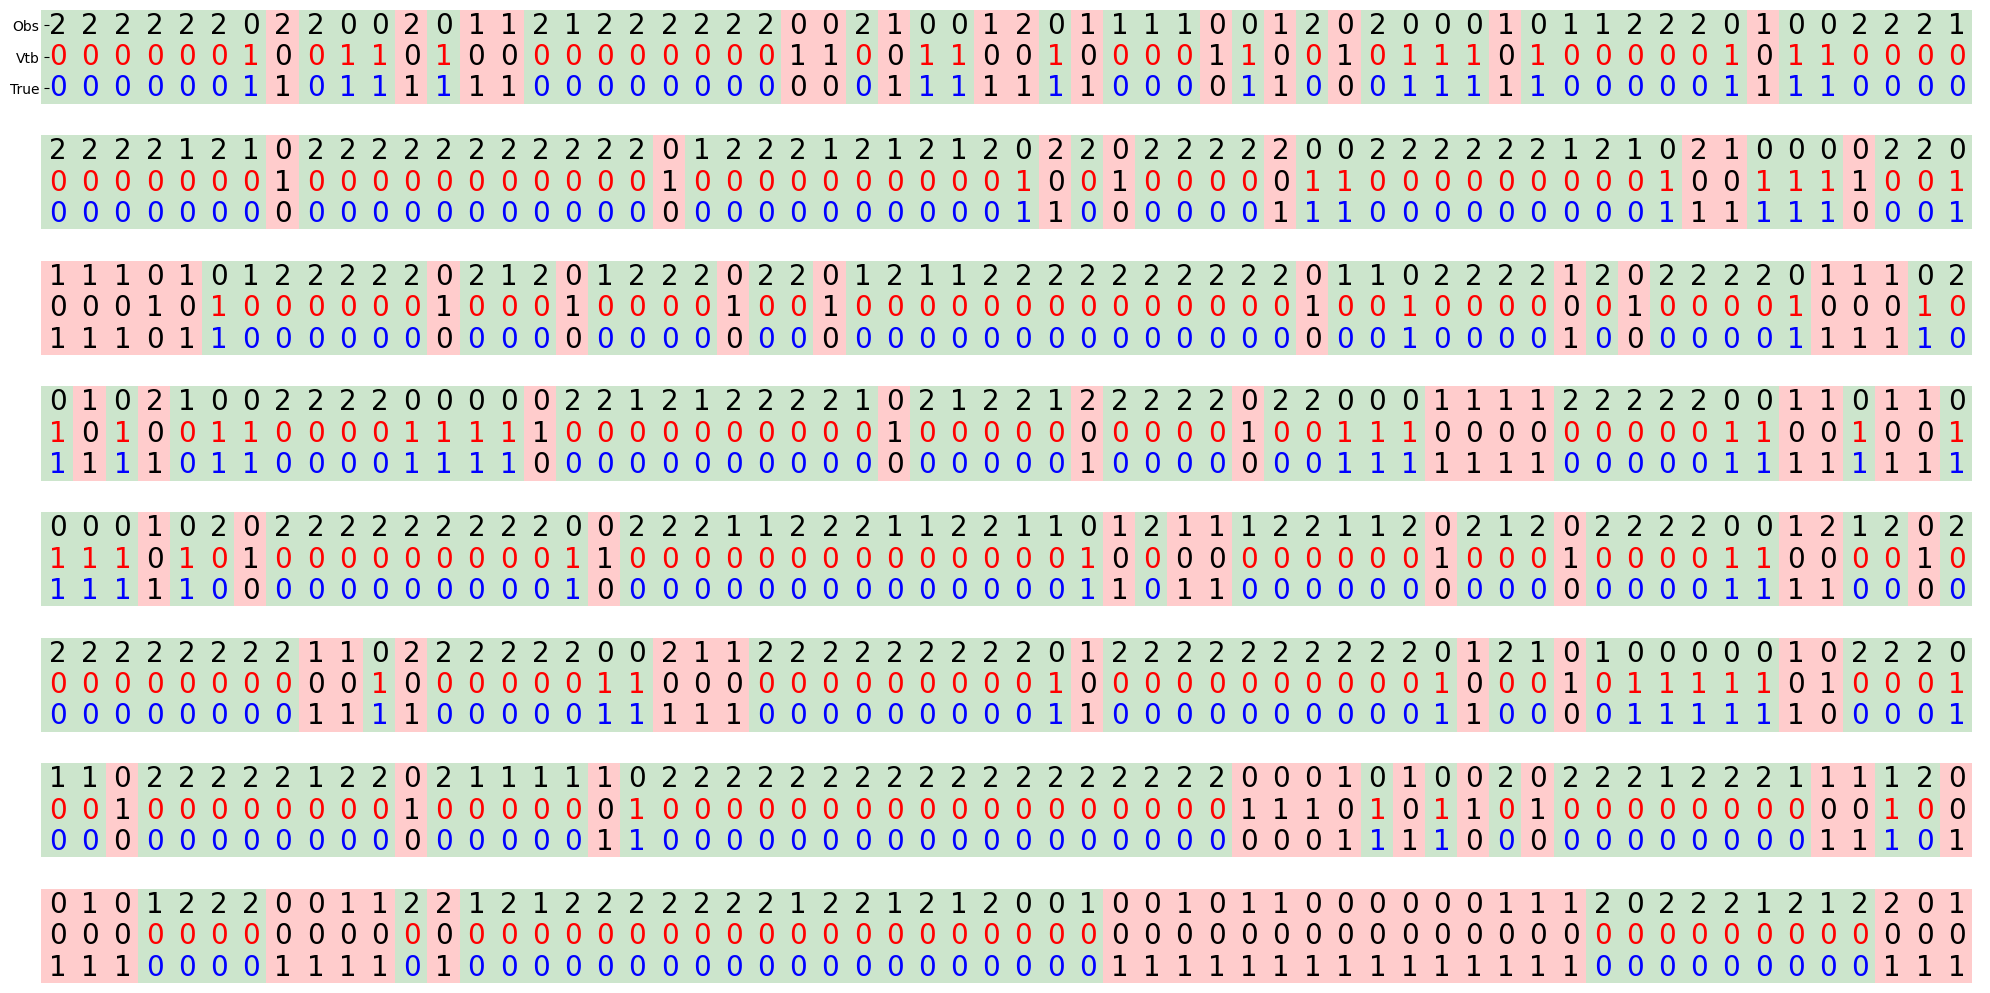

In [16]:

# Assuming Baum-Welch has already been run and returned start_prob, trans_prob, emit_prob
vtb_path = viterbi(obs_seq, start_prob, trans_prob, emit_prob)

# Read the true state path
state_seq = read_sequence_from_file(states_path)

# Visualization setup
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
CHUNK_SIZE = 60

# Iterate through chunks for visualization
for y in range(len(obs_seq) // CHUNK_SIZE):
    obs_chunk = obs_seq[CHUNK_SIZE * y: CHUNK_SIZE * (y + 1)]
    vtb_chunk = vtb_path[CHUNK_SIZE * y: CHUNK_SIZE * (y + 1)]
    state_chunk = state_seq[CHUNK_SIZE * y: CHUNK_SIZE * (y + 1)]

    for x, (obs, vtb_c, state_c) in enumerate(zip(obs_chunk, vtb_chunk, state_chunk)):
        ax.text(x, y, str(obs), fontsize=20, va='center')
        ax.text(x, y + 0.25, str(vtb_c), fontsize=20, color=['k', 'r'][int(vtb_c == state_c)], va='center')
        ax.text(x, y + 0.5, str(state_c), fontsize=20, color=['k', 'b'][int(vtb_c == state_c)], va='center')
        
        rect_color = 'g' if vtb_c == state_c else 'r'
        rect = patches.Rectangle((x - 0.25, y - 0.125), 1, 0.75, clip_on=False, fc=rect_color, alpha=0.2)
        ax.add_patch(rect)

ax.set_xlim([0, CHUNK_SIZE])
ax.set_ylim([0, len(obs_seq) // CHUNK_SIZE - 0.5])
ax.invert_yaxis()

# Hide spines and ticks
for d in ['top', 'bottom', 'left', 'right']:
    ax.spines[d].set_visible(False)
ax.set_xticks([])
ax.set_yticks([0, 0.25, 0.5])
ax.set_yticklabels(['Obs', 'Vtb', 'True'])

plt.tight_layout()
plt.show()
